In [1]:
!pip install opendatasets

In [2]:
# Import libraries
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [3]:
# Download datset from Kaggle to notebook directory
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pkhanna2
Your Kaggle Key: ··········


100%|██████████| 18.7G/18.7G [15:25<00:00, 21.7MB/s]


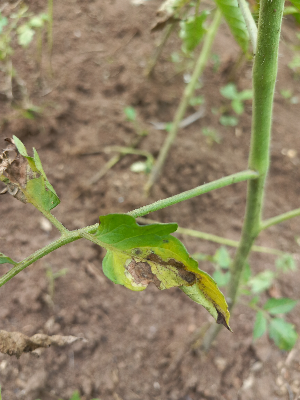

In [4]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [5]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['label_map.pbtxt',
 'Corn',
 'label_map.json',
 'dataset_labels.csv',
 'catyegory_index.pbtxt',
 'label_map.txt',
 'Tomato',
 'Pepper']

In [6]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


In [7]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

In [8]:
# Labels for categories
f = open('/content/crop-disease-ghana/input/label_map.json')
label_json = json.load(f)
label_json

{'Corn Cercospora Leaf Spot': 1,
 'Corn Common Rust': 2,
 'Corn Healthy': 3,
 'Corn Streak': 4,
 'Corn Northern Leaf Blight': 5,
 'Pepper Leaf Curl': 6,
 'Pepper Cercospora': 7,
 'Pepper Leaf Blight': 8,
 'Pepper Bacterial Spot': 9,
 'Pepper Leaf Mosaic': 10,
 'Pepper Healthy': 11,
 'Pepper Fusarium': 12,
 'Pepper Septoria': 13,
 'Pepper Late Blight': 14,
 'Pepper Early Blight': 15,
 'Tomato Late Blight': 16,
 'Tomato Early Blight': 17,
 'Tomato Bacterial Spot': 18,
 'Tomato Septoria': 19,
 'Tomato Fusarium': 20,
 'Tomato Leaf Curl': 21,
 'Tomato Healthy': 22,
 'Tomato Mosaic': 23}

<Axes: xlabel='crop', ylabel='count'>

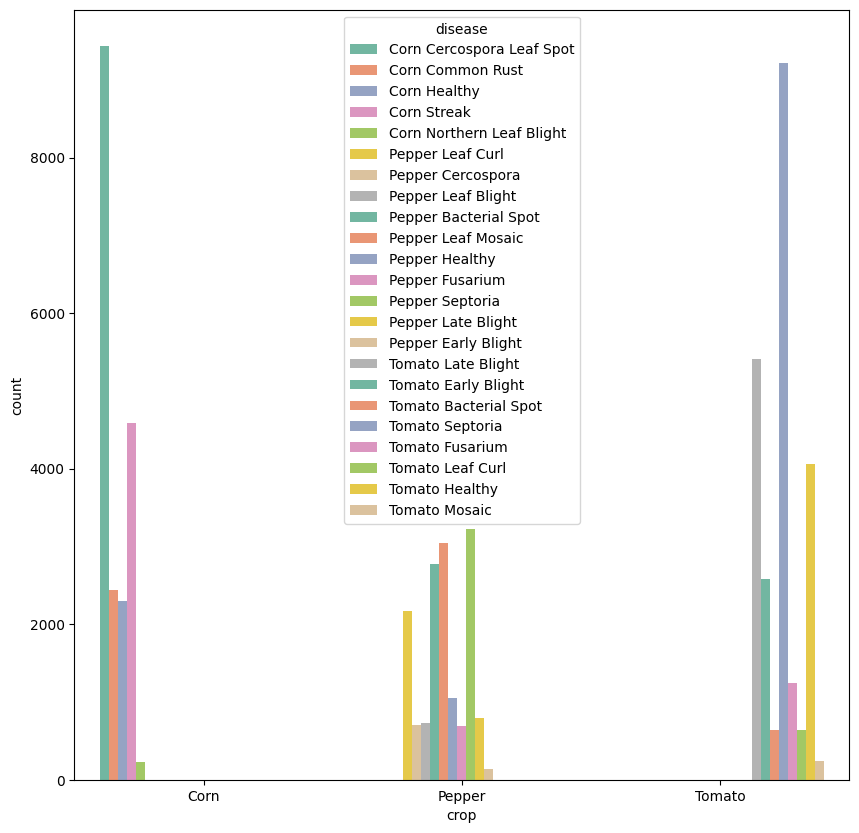

In [9]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [10]:
# Disease value counts
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Late Blight           5408
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Leaf Mosaic           3047
Pepper Bacterial Spot        2780
Tomato Early Blight          2585
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Late Blight            792
Pepper Leaf Blight            730
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Tomato Mosaic                 246
Corn Northern Leaf Blight     234
Pepper Early Blight           138
Name: disease, dtype: int64

### Looks like there is class imbalance. In order to address this problem, there should be a combination of resampling and data augmentation.

In [11]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in labels_df['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
labels_df['img_path'] = new_img
labels_df['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'

In [12]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in labels_df['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
labels_df['ann_path'] = new_ann
labels_df['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'

In [13]:
def read_bounding_boxes(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  bounding_boxes = []

  for obj in root.findall('.//object'):
      name = obj.find('name').text
      xmin = float(obj.find('.//bndbox/xmin').text)
      ymin = float(obj.find('.//bndbox/ymin').text)
      xmax = float(obj.find('.//bndbox/xmax').text)
      ymax = float(obj.find('.//bndbox/ymax').text)

      bounding_boxes.append({
          'name': name,
          'xmin': xmin,
          'ymin': ymin,
          'xmax': xmax,
          'ymax': ymax
      })

  return bounding_boxes

In [14]:
import xml.etree.ElementTree as ET
xml_file_path='/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'
bounding_boxes = read_bounding_boxes(xml_file_path)

for box in bounding_boxes:
    print(f"Name: {box['name']}, Bounding Box: ({box['xmin']}, {box['ymin']}, {box['xmax']}, {box['ymax']})")

Name: Cercospora leaf spot, Bounding Box: (2052.6533425223984, 695.8366194486982, 2210.117160578911, 785.8090543644715)
Name: Cercospora leaf spot, Bounding Box: (1110.682288077188, 901.0862366003063, 1228.7801516195727, 982.6237557427258)
Name: Cercospora leaf spot, Bounding Box: (1647.7463818056513, 912.3327909647779, 1791.1509303928324, 1002.3052258805512)
Name: Cercospora leaf spot, Bounding Box: (2491.302549965541, 1275.0341692189893, 2589.7174362508613, 1367.8182427258805)
Name: Cercospora leaf spot, Bounding Box: (3326.4231564438314, 1255.3526990811638, 3410.7787732598204, 1339.7018568147014)
Name: Cercospora leaf spot, Bounding Box: (877.2984148862853, 1511.2118108728941, 1017.8911095796002, 1592.7493300153137)
Name: Cercospora leaf spot, Bounding Box: (534.2522398345968, 799.8672473200612, 643.9145416953825, 903.8978751914242)
Name: Cercospora leaf spot, Bounding Box: (1847.3880082701585, 1595.5609686064317, 1948.6147484493451, 1677.0984877488513)
Name: Cercospora leaf spot, B

In [47]:
df=labels_df['disease'].value_counts()/5
sorted_disease_counts = df.sort_index()
sorted_disease_counts

Corn Cercospora Leaf Spot    1886.2
Corn Common Rust              486.8
Corn Healthy                  460.8
Corn Northern Leaf Blight      46.8
Corn Streak                   918.2
Pepper Bacterial Spot         556.0
Pepper Cercospora             140.8
Pepper Early Blight            27.6
Pepper Fusarium               139.2
Pepper Healthy                209.8
Pepper Late Blight            158.4
Pepper Leaf Blight            146.0
Pepper Leaf Curl              435.0
Pepper Leaf Mosaic            609.4
Pepper Septoria               644.4
Tomato Bacterial Spot         127.8
Tomato Early Blight           517.0
Tomato Fusarium               247.6
Tomato Healthy                813.2
Tomato Late Blight           1081.6
Tomato Leaf Curl              128.2
Tomato Mosaic                  49.2
Tomato Septoria              1842.2
Name: disease, dtype: float64

In [38]:
np.unique(labels_df['disease'])

array(['Corn Cercospora Leaf Spot', 'Corn Common Rust', 'Corn Healthy',
       'Corn Northern Leaf Blight', 'Corn Streak',
       'Pepper Bacterial Spot', 'Pepper Cercospora',
       'Pepper Early Blight', 'Pepper Fusarium', 'Pepper Healthy',
       'Pepper Late Blight', 'Pepper Leaf Blight', 'Pepper Leaf Curl',
       'Pepper Leaf Mosaic', 'Pepper Septoria', 'Tomato Bacterial Spot',
       'Tomato Early Blight', 'Tomato Fusarium', 'Tomato Healthy',
       'Tomato Late Blight', 'Tomato Leaf Curl', 'Tomato Mosaic',
       'Tomato Septoria'], dtype=object)

In [49]:
# Create balanced dataset
df_balanced = pd.DataFrame(columns = labels_df.columns)
indx=0
for i in np.unique(labels_df['disease']):
  df = labels_df[labels_df['disease']==i]
  samp = df.sample(n = int(sorted_disease_counts[indx]))
  df_balanced = df_balanced.append(samp,ignore_index = True)
  indx=indx+1

<ipython-input-49-5f67aa0d7ee8>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df_balanced.append(samp,ignore_index = True)


In [50]:
df_balanced

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape
0,20230526_102413.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1513.962264,1080.458560,1605.199161,1134.626262,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
1,20230525_112238(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3940.293501,1245.812597,4037.232704,1328.489616,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
2,20230525_112003.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2421.006203,392.179652,2485.678842,456.847339,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
3,20230524_110138.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2591.898017,467.538484,2681.473088,562.952657,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
4,20230525_111146.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1356.169014,1153.605634,1528.563380,1245.549296,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11658,IMG_6218.jpeg,Tomato Septoria,Tomato,4032,3024,3,2403.624232,2153.512807,2484.019754,2245.384734,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)"
11659,2N8A1306.JPG,Tomato Septoria,Tomato,1920,1280,3,828.507026,819.350117,865.930913,880.327869,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(1920, 1280)"
11660,IMG_6322.jpeg,Tomato Septoria,Tomato,4032,3024,3,1678.635237,1111.759832,1845.589970,1266.541458,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)"
11661,2N8A2440.JPG,Tomato Septoria,Tomato,1920,1280,3,679.177019,265.724638,854.301242,371.609731,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(1920, 1280)"


In [51]:
df_balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    1886
Tomato Septoria              1842
Tomato Late Blight           1081
Corn Streak                   918
Tomato Healthy                813
Pepper Septoria               644
Pepper Leaf Mosaic            609
Pepper Bacterial Spot         556
Tomato Early Blight           517
Corn Common Rust              486
Corn Healthy                  460
Pepper Leaf Curl              435
Tomato Fusarium               247
Pepper Healthy                209
Pepper Late Blight            158
Pepper Leaf Blight            146
Pepper Cercospora             140
Pepper Fusarium               139
Tomato Leaf Curl              128
Tomato Bacterial Spot         127
Tomato Mosaic                  49
Corn Northern Leaf Blight      46
Pepper Early Blight            27
Name: disease, dtype: int64

In [19]:
# Define padding function
# Use this tutorial as a guide:
# https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def pad_img(im,top, right, bottom =0, left = 0, color = (0,0,0)):

    photo = Image.open(im)
    size = photo.size
    new_width = size[0] + right + left
    new_height = size[1] + top + bottom
    result = Image.new(photo.mode, (new_width, new_height), color)
    result.paste(photo, (left, top))
    return result
# Test out function
pad_img(df_balanced['img_path'][0],500,350)
#display_image(test_img)

Output hidden; open in https://colab.research.google.com to view.

In [52]:
new_xmin = []
new_ymin = []
new_xmax = []
new_ymax = []

for i in range(df_balanced.shape[0]):
  w=df_balanced['width'][i]
  h=df_balanced['height'][i]
  xmin=df_balanced['xmin'][i]
  ymin=df_balanced['ymin'][i]
  xmax=df_balanced['xmax'][i]
  ymax=df_balanced['ymax'][i]
  new_xmin.append(float(xmin) / w)
  new_ymin.append(float(ymin) / h)
  new_xmax.append(float(xmax) / w)
  new_ymax.append(float(ymax) / h)

df_balanced['xmin'] = new_xmin
df_balanced['ymin'] = new_ymin
df_balanced['xmax'] = new_xmax
df_balanced['ymax'] = new_ymax
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape
0,20230526_102413.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.371069,0.588485,0.393431,0.617988,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
1,20230525_112238(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.965758,0.678547,0.989518,0.723578,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
2,20230525_112003.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.593384,0.213605,0.609235,0.248828,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
3,20230524_110138.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.635269,0.254651,0.657224,0.306619,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
4,20230525_111146.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.332394,0.628326,0.374648,0.678404,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"


In [53]:
width=224
height=224
depth= 3
epoch_= 25
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
#root_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
INIT_LR = 1e-3


In [54]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [55]:
image_list, label_list, bboxes_list, imagePaths_list = [], [], [], []
indx=0
try:
  for img_dir in df_balanced['img_path']:
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
        image_list.append(convert_image_to_array(img_dir))
        label_list.append(df_balanced['disease'][indx])
        bboxes_list.append((df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx]))
        imagePaths_list.append(df_balanced['img_path'][indx])
        indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [56]:
data, labels, bboxes, imagePaths = [], [], [], []
data = np.array(image_list, dtype="float32") / 255.0
labels = np.array(label_list)
bboxes = np.array(bboxes_list, dtype="float32")
imagePaths = np.array(imagePaths_list)

In [57]:
print (data[0], labels[0], bboxes[0], imagePaths[0])

[[[0.         0.6901961  0.41960785]
  [0.         0.7019608  0.48235294]
  [0.1882353  0.6666667  0.5764706 ]
  ...
  [0.7647059  0.9098039  0.7529412 ]
  [0.76862746 0.9254902  0.7647059 ]
  [0.7411765  0.8980392  0.7372549 ]]

 [[0.         0.6901961  0.4       ]
  [0.         0.69411767 0.44705883]
  [0.14509805 0.65882355 0.5294118 ]
  ...
  [0.80784315 0.9529412  0.8039216 ]
  [0.6862745  0.8392157  0.6901961 ]
  [0.74509805 0.9019608  0.7372549 ]]

 [[0.         0.68235296 0.4       ]
  [0.         0.6784314  0.41960785]
  [0.10588235 0.6901961  0.53333336]
  ...
  [0.78431374 0.9372549  0.7882353 ]
  [0.75686276 0.9019608  0.7529412 ]
  [0.7372549  0.89411765 0.7294118 ]]

 ...

 [[0.24705882 0.68235296 0.57254905]
  [0.24705882 0.69411767 0.6       ]
  [0.25490198 0.65882355 0.5372549 ]
  ...
  [0.27450982 0.6392157  0.4392157 ]
  [0.25490198 0.61960787 0.41960785]
  [0.22745098 0.6039216  0.42352942]]

 [[0.2627451  0.63529414 0.43529412]
  [0.2509804  0.627451   0.43137255]


In [58]:
label_binarizer = LabelBinarizer()
if labels is not None:
  labels = label_binarizer.fit_transform(labels)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [59]:
print(label_binarizer.classes_)

['Corn Cercospora Leaf Spot' 'Corn Common Rust' 'Corn Healthy'
 'Corn Northern Leaf Blight' 'Corn Streak' 'Pepper Bacterial Spot'
 'Pepper Cercospora' 'Pepper Early Blight' 'Pepper Fusarium'
 'Pepper Healthy' 'Pepper Late Blight' 'Pepper Leaf Blight'
 'Pepper Leaf Curl' 'Pepper Leaf Mosaic' 'Pepper Septoria'
 'Tomato Bacterial Spot' 'Tomato Early Blight' 'Tomato Fusarium'
 'Tomato Healthy']


In [60]:
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [61]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [75]:
#augimage=[]
#aug_iter=aug.flow(trainImages, batch_size=BS)
#augimage=next(aug_iter)[0].astype('uint8')
#aug_image_count=len(aug_iter) * BS
#for i in range(aug_image_count):
#  augimage.append(next(aug_iter)[0].astype('uint8'))


In [78]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [79]:

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58889256/58889256 [==============================] - 3s 0us/step


In [80]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(label_binarizer.classes_), activation="softmax", name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [81]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [82]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [83]:
trainTargets

{'class_label': array([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0]]),
 'bounding_box': array([[0.5408805 , 0.34624904, 0.5709294 , 0.39593846],
        [0.5346521 , 0.4612851 , 0.5850458 , 0.5021178 ],
        [0.02274294, 0.46322262, 0.252929  , 0.6837433 ],
        ...,
        [0.53962785, 0.29936352, 0.5658167 , 0.34377393],
        [0.7161409 , 0.5537207 , 0.78355384, 0.70188034],
        [0.5106725 , 0.49686238, 0.55206406, 0.5474111 ]], dtype=float32)}

In [84]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
  #aug.flow(trainImages, trainTargets, batch_size=BS),
	validation_data=(testImages, testTargets),
	batch_size=BS,
	epochs=25,
	verbose=1)

[INFO] training model...
Epoch 1/25
195/195 [==============================] - 22s 46ms/step - loss: 2.4233 - bounding_box_loss: 0.0571 - class_label_loss: 2.3663 - bounding_box_accuracy: 0.4798 - class_label_accuracy: 0.2977 - val_loss: 1.8999 - val_bounding_box_loss: 0.0566 - val_class_label_loss: 1.8433 - val_bounding_box_accuracy: 0.4265 - val_class_label_accuracy: 0.4200
Epoch 2/25
195/195 [==============================] - 6s 32ms/step - loss: 1.9744 - bounding_box_loss: 0.0482 - class_label_loss: 1.9263 - bounding_box_accuracy: 0.5210 - class_label_accuracy: 0.3618 - val_loss: 1.6422 - val_bounding_box_loss: 0.0489 - val_class_label_loss: 1.5933 - val_bounding_box_accuracy: 0.4830 - val_class_label_accuracy: 0.4586
Epoch 3/25
195/195 [==============================] - 6s 32ms/step - loss: 1.8413 - bounding_box_loss: 0.0456 - class_label_loss: 1.7957 - bounding_box_accuracy: 0.5436 - class_label_accuracy: 0.3796 - val_loss: 1.5696 - val_bounding_box_loss: 0.0502 - val_class_label

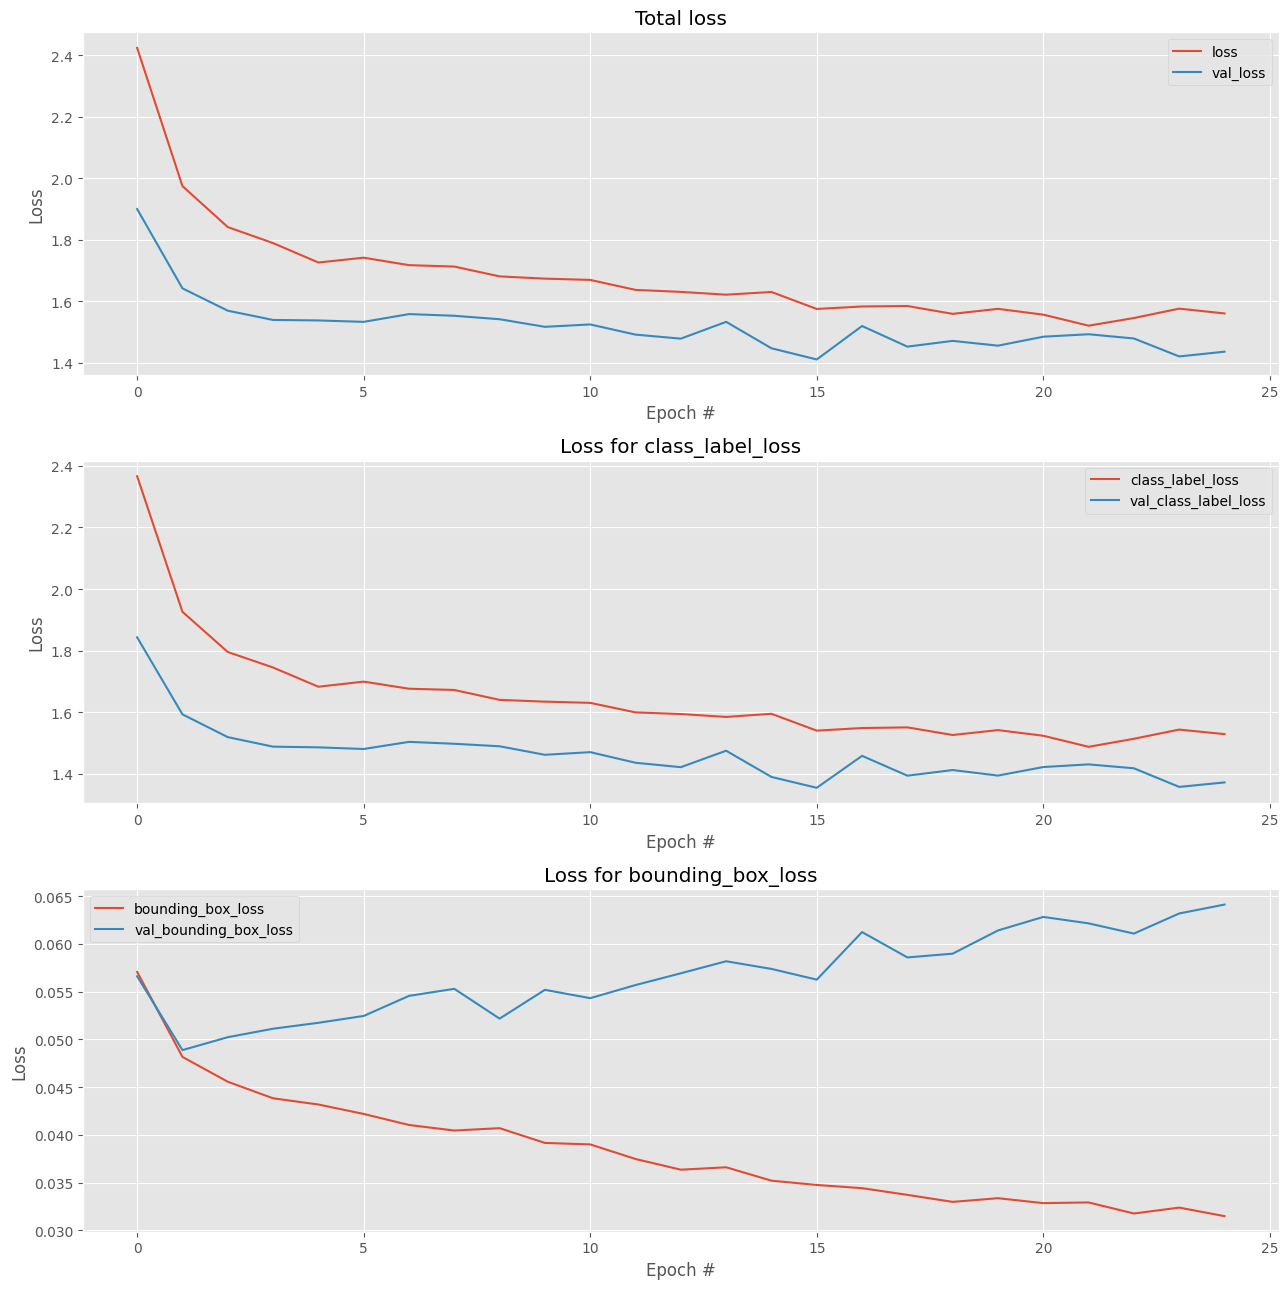

In [85]:
# plot the total loss, label loss, and bounding box loss
epochs=25
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

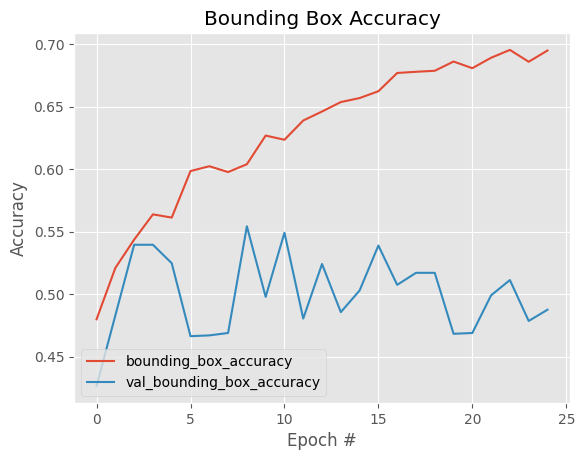

In [86]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


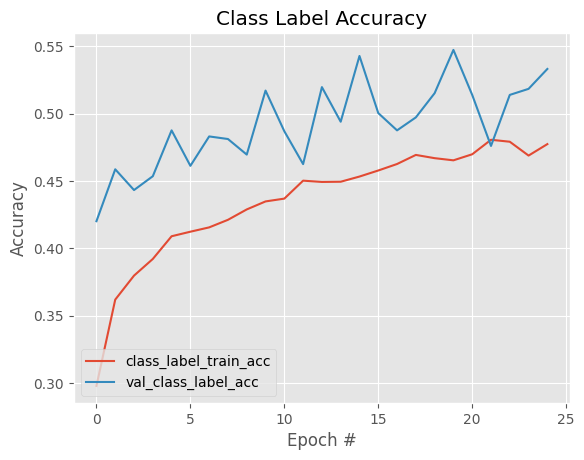

In [87]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [88]:
img = '/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104759.jpg'

In [89]:
# loop over the images that we'll be testing using our bounding box
# regression model
#for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]

image = load_img(img, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
# determine the class label with the largest predicted
# probability
i = np.argmax(labelPreds, axis=1)
label = label_binarizer.classes_[i][0]

1/1 [==============================] - 0s 430ms/step


In [90]:
print(startX, startY, endX, endY)

0.37687862 0.5140436 0.47407344 0.63378114


In [91]:
print(label)

Corn Cercospora Leaf Spot


150 308 189 380


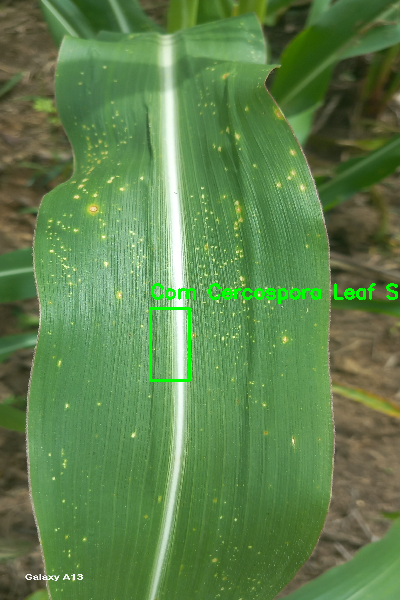

-1

In [92]:
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
from imutils import paths

image = cv2.imread(img)
image = image.copy()
image = cv2.resize(image, (400, 600))
#image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX, startY, endX, endY)
# draw the predicted bounding box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [100]:
scores = model.evaluate(testImages, testTargets)
print(f"Test Bounding Box Accuracy: {scores[3]*100}")
print(f"Test Class Label Accuracy: {scores[4]*100}")

49/49 [==============================] - 1s 24ms/step - loss: 1.4365 - bounding_box_loss: 0.0641 - class_label_loss: 1.3723 - bounding_box_accuracy: 0.4875 - class_label_accuracy: 0.5331
Test Bounding Box Accuracy: 48.74759018421173
Test Class Label Accuracy: 53.30764055252075
